In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.datasets as dataset
import torch.utils.data as td
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import time

gpu_boole = torch.cuda.is_available()
print(gpu_boole)

transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)])

training = dataset.FashionMNIST(root ='./data', transform=transform, train=True, download=True)
testing =  dataset.FashionMNIST(root ='./data', transform = transform, train=False, download=True)

train, valid = td.random_split(training, [50000, 10000], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(dataset=train, batch_size = 128, shuffle=True)
valid_loader = DataLoader(dataset=valid, batch_size = 128, shuffle=False)
test_loader = DataLoader(dataset=testing, batch_size = 128, shuffle=False)

True


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


torch.Size([1, 224, 224])


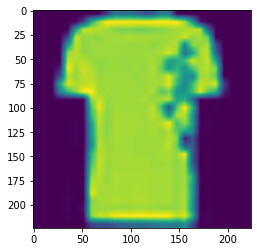

Label tensor(0)


In [2]:
## Plotting data to make sure it is correct:
x,y = next(iter(train_loader))
plt.imshow(x[3][0].cpu().data.numpy()) #plotting first channel of first image of MNIST
print(x[3].shape)
plt.show()
print('Label', y[3])

In [3]:
def train_eval(net, loss_metric, verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in train_loader:
        images = images.repeat(1,3,1,1)

        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()

        outputs = net(images).detach() 
        _, predicted = torch.max(outputs.data, 1) 
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels).detach()
        
        
    if verbose:
        print('Train accuracy: %f %%' % (100.0 * correct / total))
        print('Train loss: %f' % (loss_sum.cpu().data.numpy().item() / total))

    return 100.0 * correct / total, loss_sum.cpu().data.numpy().item() / total


def valid_eval(net, loss_metric, verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in valid_loader:
        images = images.repeat(1,3,1,1)

        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()

        outputs = net(images).detach() 
        _, predicted = torch.max(outputs.data, 1) 
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels).detach()

    if verbose:
        print('Validation accuracy: %f %%' % (100.0 * correct / total))
        print('Validation loss: %f' % (loss_sum.cpu().data.numpy().item() / total))

    return 100.0 * correct / total, loss_sum.cpu().data.numpy().item() / total
    

def test_eval(net, loss_metric, verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in test_loader:
        images = images.repeat(1,3,1,1)

        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()

        outputs = net(images).detach() 
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels).detach()

    if verbose:
        print('Test accuracy: %f %%' % (100.0 * correct / total))
        print('Test loss: %f' % (loss_sum.cpu().data.numpy().item() / total))

    return 100.0 * correct / total, loss_sum.cpu().data.numpy().item() / total

In [4]:
def train(net, loss_metric, optimizer, epochs=10):
    #defining batch train loss recording arrays for later visualization/plotting:
    loss_batch_store = []
    valid_acc = []

    print("Starting Training")
    #training loop:
    for epoch in range(epochs):
      time1 = time.time() #timekeeping

      for i, (x,y) in enumerate(train_loader):

        if gpu_boole:
          x = x.cuda()
          y = y.cuda()

        x = x.repeat(1,3,1,1)

        #loss calculation and gradient update:
        optimizer.zero_grad()

        outputs = net.forward(x)
        loss = loss_metric(outputs,y)
        loss.backward()    

        ##performing update:
        optimizer.step()

      print("Epoch",epoch+1,':')
      train_perc, train_loss = train_eval(net, loss_metric)
      valid_perc, valid_loss = valid_eval(net, loss_metric)

      valid_acc.append(valid_perc)
      loss_batch_store.append(train_loss)

      time2 = time.time() #timekeeping
      print('Elapsed time for epoch:',time2 - time1,'s')
      print('ETA of completion:',(time2 - time1)*(epochs - epoch - 1)/60,'minutes')
      print()

    return loss_batch_store, valid_acc

### a)

In [5]:
net = models.vgg16()
net.classifier[6] = nn.Linear(4096, 10)


if gpu_boole:
  net = net.cuda()

opt = torch.optim.SGD(net.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()

loss_store, acc = train(net, loss, opt)

Starting Training
Epoch 1 :
Train accuracy: 81.026001 %
Train loss: 0.003969
Validation accuracy: 80.729996 %
Validation loss: 0.004114
Elapsed time for epoch: 282.536025762558 s
ETA of completion: 42.380403864383695 minutes

Epoch 2 :
Train accuracy: 78.972000 %
Train loss: 0.004066
Validation accuracy: 78.309998 %
Validation loss: 0.004174
Elapsed time for epoch: 282.26423025131226 s
ETA of completion: 37.635230700174965 minutes

Epoch 3 :
Train accuracy: 86.124001 %
Train loss: 0.002906
Validation accuracy: 85.579994 %
Validation loss: 0.003104
Elapsed time for epoch: 282.3258273601532 s
ETA of completion: 32.93801319201787 minutes

Epoch 4 :
Train accuracy: 87.136002 %
Train loss: 0.002727
Validation accuracy: 86.220001 %
Validation loss: 0.002930
Elapsed time for epoch: 282.3305115699768 s
ETA of completion: 28.233051156997682 minutes

Epoch 5 :
Train accuracy: 88.197998 %
Train loss: 0.002524
Validation accuracy: 87.459999 %
Validation loss: 0.002778
Elapsed time for epoch: 282.3

In [6]:
torch.save(net.state_dict(), "VGG_16.pt")

In [7]:
test_acc = test_eval(net, loss)
print(test_acc)

Test accuracy: 88.689995 %
Test loss: 0.002466
(tensor(88.6900, device='cuda:0'), 0.0024661314010620116)


### b)

In [21]:
model = models.vgg16()
model.classifier[6] = nn.Linear(4096, 10)
model.load_state_dict(torch.load("VGG_16.pt"))

for name, param in model.named_parameters():
  if not "classifier.6" in name:
    param.requires_grad = False

torch.nn.init.xavier_normal_(model.classifier[6].weight)
torch.nn.init.zeros_(model.classifier[6].bias)

if gpu_boole:
  model = model.cuda()

opt = torch.optim.SGD(model.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()

loss_store, acc = train(model, loss, opt)

Starting Training
Epoch 1 :
Train accuracy: 88.159996 %
Train loss: 0.002546
Validation accuracy: 87.180000 %
Validation loss: 0.002848
Elapsed time for epoch: 144.68310260772705 s
ETA of completion: 21.70246539115906 minutes

Epoch 2 :
Train accuracy: 89.337997 %
Train loss: 0.002319
Validation accuracy: 87.879997 %
Validation loss: 0.002651
Elapsed time for epoch: 144.75087451934814 s
ETA of completion: 19.300116602579752 minutes

Epoch 3 :
Train accuracy: 89.526001 %
Train loss: 0.002251
Validation accuracy: 88.040001 %
Validation loss: 0.002675
Elapsed time for epoch: 144.804869890213 s
ETA of completion: 16.893901487191517 minutes

Epoch 4 :
Train accuracy: 89.737999 %
Train loss: 0.002218
Validation accuracy: 88.659996 %
Validation loss: 0.002532
Elapsed time for epoch: 144.7159035205841 s
ETA of completion: 14.47159035205841 minutes

Epoch 5 :
Train accuracy: 90.068001 %
Train loss: 0.002132
Validation accuracy: 88.659996 %
Validation loss: 0.002462
Elapsed time for epoch: 144.7

In [23]:
test_acc = test_eval(model, loss)
print(test_acc)

Test accuracy: 88.079994 %
Test loss: 0.002615
(tensor(88.0800, device='cuda:0'), 0.002614918518066406)


### c)

In [24]:
model = models.vgg16()
model.classifier[6] = nn.Linear(4096, 10)
model.load_state_dict(torch.load("VGG_16.pt"))

for name, param in model.named_parameters():
  if not "classifier" in name:
    param.requires_grad = False
  else:
    if "weight" in name:
      torch.nn.init.xavier_normal_(param)
    if "bias" in name:
      torch.nn.init.zeros_(param)

if gpu_boole:
  model = model.cuda()

opt = torch.optim.SGD(model.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()

loss_store, acc = train(model, loss, opt)

Starting Training
Epoch 1 :
Train accuracy: 86.157997 %
Train loss: 0.002948
Validation accuracy: 85.790001 %
Validation loss: 0.003123
Elapsed time for epoch: 147.86622405052185 s
ETA of completion: 22.179933607578278 minutes

Epoch 2 :
Train accuracy: 87.306000 %
Train loss: 0.002650
Validation accuracy: 86.570000 %
Validation loss: 0.002904
Elapsed time for epoch: 147.89103627204895 s
ETA of completion: 19.718804836273193 minutes

Epoch 3 :
Train accuracy: 89.311996 %
Train loss: 0.002293
Validation accuracy: 88.570000 %
Validation loss: 0.002562
Elapsed time for epoch: 147.87922430038452 s
ETA of completion: 17.252576168378194 minutes

Epoch 4 :
Train accuracy: 90.005997 %
Train loss: 0.002151
Validation accuracy: 88.320000 %
Validation loss: 0.002526
Elapsed time for epoch: 147.86277532577515 s
ETA of completion: 14.786277532577515 minutes

Epoch 5 :
Train accuracy: 89.900002 %
Train loss: 0.002145
Validation accuracy: 88.540001 %
Validation loss: 0.002537
Elapsed time for epoch: 

In [25]:
test_acc = test_eval(model, loss)
print(test_acc)

Test accuracy: 88.709999 %
Test loss: 0.002457
(tensor(88.7100, device='cuda:0'), 0.0024568952560424804)
